In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.layers import advanced_activations
from keras.callbacks import EarlyStopping

In [92]:
rides = pd.read_csv('Bike-Sharing-Dataset/hour.csv')

rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [93]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [94]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [95]:
# Save data for approximately the last 21 days 
test = data[-21*24:]
y_test = test['cnt']
X_test = test.drop(['casual', 'registered', 'cnt'], axis=1)
# Now remove the test data from the data set 
data = data[:-21*24]
y = data['cnt']
X = data.drop(['casual', 'registered', 'cnt'], axis=1)

## Neural Network

In [100]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.0000001, patience=6)

model = Sequential()
model.add(Dense(64, input_dim=56))
model.add(advanced_activations.PReLU())
model.add(Dropout(0.25, seed=42))
model.add(Dense(32))
model.add(advanced_activations.PReLU())
model.add(Dropout(0.5, seed=42))
model.add(Dense(16))
model.add(advanced_activations.PReLU())
model.add(Dropout(0.25, seed=42))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam');
hist = model.fit(np.array(X),  np.array(y),  validation_split=0.1, 
          epochs=100,
          batch_size=32,
               callbacks=[callbacks], verbose=1);

Train on 15187 samples, validate on 1688 samples
Epoch 1/100
15187/15187 [==============================] - 2s - loss: 0.6212 - val_loss: 0.5801
Epoch 2/100
15187/15187 [==============================] - 1s - loss: 0.3408 - val_loss: 0.3997
Epoch 3/100
15187/15187 [==============================] - 1s - loss: 0.2529 - val_loss: 0.3012
Epoch 4/100
15187/15187 [==============================] - 1s - loss: 0.1967 - val_loss: 0.2022
Epoch 5/100
15187/15187 [==============================] - 1s - loss: 0.1739 - val_loss: 0.1945
Epoch 6/100
15187/15187 [==============================] - 1s - loss: 0.1539 - val_loss: 0.1809
Epoch 7/100
15187/15187 [==============================] - 1s - loss: 0.1430 - val_loss: 0.1808
Epoch 8/100
15187/15187 [==============================] - 2s - loss: 0.1399 - val_loss: 0.1749
Epoch 9/100
15187/15187 [==============================] - 1s - loss: 0.1316 - val_loss: 0.1731
Epoch 10/100
15187/15187 [==============================] - 1s - loss: 0.1258 - val_los

In [102]:
score = model.evaluate(np.array(X_test), np.array(y_test),verbose=0)
score

0.085957088285968417

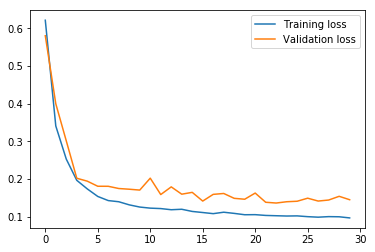

In [103]:
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.legend()
_ = plt.ylim()

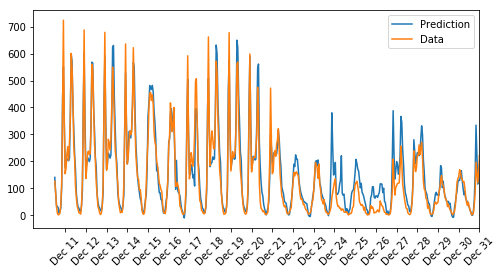

In [104]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = model.predict(np.array(X_test), batch_size=16).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((y_test*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.loc[test.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

### Random Forest

In [107]:
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

In [180]:
#kf = KFold(n_splits=10, shuffle=True, random_state=17)
forest_params = {'max_features': [40, 45, 50], 'max_depth': [i for i in range(8,20,2)]}

forest_model = GridSearchCV(RandomForestRegressor(n_estimators = 100, random_state=17, min_samples_leaf=1,
                                                         n_jobs=-1),
                                 forest_params, cv=7,  verbose=1)

forest_model.fit(X, y)

Fitting 7 folds for each of 18 candidates, totalling 126 fits


[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:  7.5min finished


GridSearchCV(cv=7, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [40, 45, 50], 'max_depth': [8, 10, 12, 14, 16, 18]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [195]:
rf = RandomForestRegressor(n_estimators = 53, random_state=17, max_features=50, min_samples_leaf=1, max_depth=18,
                                                         n_jobs=-1)
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
           max_features=50, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=53, n_jobs=-1, oob_score=False, random_state=17,
           verbose=0, warm_start=False)

In [203]:
forest_predict =  rf.predict(X_test)
score_mse = mean_squared_error(y_test, forest_predict)
score_mse

0.15261978644579852

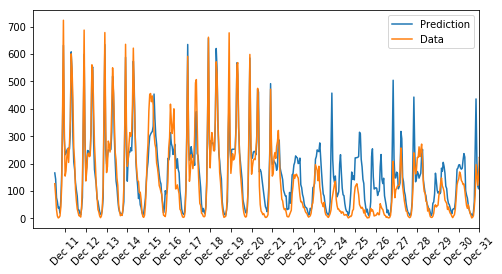

In [197]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions_f = forest_predict.T*std + mean
ax.plot(predictions_f, label='Prediction')
ax.plot((y_test*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.loc[test.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

### Сравнение нейронной сети и randomforest

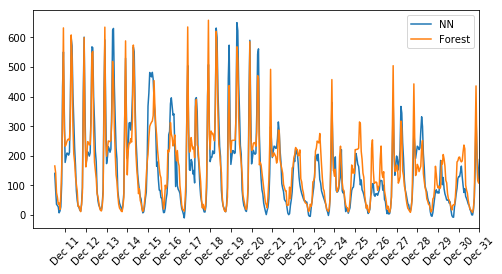

In [198]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions_f = forest_predict.T*std + mean
ax.plot(predictions[0], label='NN')
ax.plot(predictions_f, label='Forest')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.loc[test.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

In [209]:
scores = pd.DataFrame({'NN': score, 'RandomForest': score_mse}, index=['score_mse'])
scores

,NN,RandomForest
score_mse,0.08596,0.15262
